In [2]:
from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import SentenceTransformerEmbedder
from models.embedder_with_classification_head.classification_heads import NeuralNetClassifier, GenericSklearnCalssifier

from datetime import datetime
from matplotlib.colors import ListedColormap

from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, Matern
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import random
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler
import os
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler



In [25]:
## search space 
all_search_space = {
        MLPClassifier :{
                'hidden_layer_sizes': [(50,), (100, 50), (64, 32), (32,), (32, 16)],
                'activation': ['tanh', 'relu'],
                'solver': ['adam', 'sgd'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.0001, 0.001, 0.01],
                'max_iter': [500, 1000, 1500],
                "random_state": [42],
                "early_stopping": [False, True]
        },
        KNeighborsClassifier: {
        "n_neighbors" : [3, 5, 10],
        "weights" : ["uniform", "distance"]
        },

        SVC: {
            "C" : [0.1, 1.0, 100],
            "kernel": ["rbf", "linear", "poly"],
            "degree": [2, 3, 4],
            "gamma": ["scale", "auto", 0.0001, 0.01],
            "random_state": [42],
            "probability": [True]
        },

        GaussianProcessClassifier: {
        "kernel": [(1.0 * RBF(1.0), ),
                RBF(length_scale=1.0), 
                ConstantKernel(1.0) * RBF(length_scale=1.0),
                Matern(length_scale=1.0, nu=1.5),
                DotProduct()]
        },

        DecisionTreeClassifier: {
            "criterion": ["gini", "log_loss", "entropy"],
            "max_depth": [2, 5, 10, None],
            "random_state": [42]
        },

        RandomForestClassifier: {
            "max_depth":[5,10, None], 
            "n_estimators": [10, 100, 500, 1000], 
            "max_features": ["sqrt", "log2", None], 
            "random_state": [42],
            "class_weight": ["balanced", "balanced_subsample"]
        },

        AdaBoostClassifier : {
                "random_state":[42],
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1]
        }
}


### narrower search space 
narrower_search_space =  {
        MLPClassifier :{
                'hidden_layer_sizes': [(64,), (100, 50), (64, 32) ],
                'activation': ['relu'],
                'solver': ['adam'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.0001, 0.001, 0.01],
                'max_iter': [500, 1000, 1500, 2000],
                "random_state": [42],
                "early_stopping": [False, True]
        },
        KNeighborsClassifier: {
        "n_neighbors" : [3, 5, 10, 20],
        "weights" : ["uniform", "distance"]
        },

        SVC: {
            "C" : [0.1, 1.0, 100],
            "kernel": ["rbf", "linear", "poly"],
            "degree": [2, 3],
            "gamma": ["scale", "auto", 0.0001, 0.01],
            "random_state": [42],
            "probability": [True]
        }
}

all_search_space = narrower_search_space


In [26]:
emebbder_space = ["pritamdeka/S-PubMedBert-MS-MARCO",
                    "NeuML/pubmedbert-base-embeddings",
                    "pritamdeka/S-BioBert-snli-multinli-stsb",
                    "all-MiniLM-L6-v2",
                    "all-mpnet-base-v2",
                    "sentence-transformers/all-MiniLM-L6-v2",
                    "kamalkraj/BioSimCSE-BioLinkBERT-BASE",
                    "potsu-potsu/bge-base-biomedical-matryoshka-v3",
                    "LiquidAI/LFM2-ColBERT-350M"
                    ]

## add it to the config 
emebbder_key = "emebbder__name"
for k in all_search_space.keys():
    all_search_space[k][emebbder_key] = emebbder_space

In [27]:
resample_key = "dataloader__resample"
classratio_key = "dataloader__classs_ratio"

dataloader_search_space = {
    resample_key: [False, True],
    classratio_key: [None, 
                    {0: 2, 1: 0.25, 2: 1},
                    {0: 2, 1: 0.5, 2: 1},
                    {0: 0.5, 1: 0.5, 2: 1},
                    {0: 0.25, 1: 0.25, 2: 1}]
}

for k in all_search_space.keys():
    all_search_space[k][resample_key] = dataloader_search_space[resample_key]
    all_search_space[k][classratio_key] = dataloader_search_space[classratio_key]

In [28]:
from sklearn.model_selection import ParameterGrid


# x = GridSearchCV(param_grid=narrower_search_space)
x= ParameterGrid(all_search_space[MLPClassifier])
len(x)

19440

In [ ]:
configs_per_cls = 250

all_configs_per_cls = {}
REPORT_FOLDER = "reports"

if not os.path.exists(REPORT_FOLDER):
    os.makedirs(REPORT_FOLDER)


for cls, search_space_cls in all_search_space.items():

    sampler = ParameterSampler(
        param_distributions=search_space_cls,
        n_iter=configs_per_cls
        )
    all_configs_per_cls[cls] = list(sampler)

dataloader = AnnotationDataLoader()

i = 0
for cls, configs in all_configs_per_cls.items():
    for config in configs: 
        i = i + 1
        try:
            # resmaple can be false bu class ratio not, this can be confusign when viewign the config
            if not config[resample_key]:
                config[classratio_key] = None

            config_str = str(config)
            # embedder config
            embedder_name = config.pop(emebbder_key)

            # data loader config 
            resample = config.pop(resample_key)
            classratio = config.pop(classratio_key)

            # create models
            embedder = SentenceTransformerEmbedder(embedder_name)
            classifier = GenericSklearnCalssifier(cls, model_kwargs=config)
            embedder_m = EmbedderClassifier(embedder, classifier)

            # setup title and info
            escaped_name = embedder_name.replace('/', '_').replace('\\', '_')
            model_title = f"{escaped_name} with {cls.__name__} config {i}"
            info_str = f"EmbedderClassifier({embedder.__class__.__name__}, {cls.__name__}) || {config_str}"
            embedder_m.model_title = model_title
            embedder_m.model_info = info_str

            embedder_m.train(dataloader.get_train(resample=resample, class_ratio=classratio))

            # eval the model
            filename_base = datetime.now().strftime(r"%Y%m%d_%H%M%S_Emebdder")
            m = ModelEvaluator(embedder_m, dataloader.get_validation())
            c_report = m.generate_report(include_probablities=True)
            report_path = os.path.join(REPORT_FOLDER, f"{filename_base}_{embedder_m.model_title}.rep")
            c_report.save_to_file(report_path)
        except Exception as e:
            print(e)           


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Elon\anaconda3\envs\main\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Elon\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Original Training Class Distribution: Counter({0: 6120, 2: 3060, 1: 765})


In [8]:
from model_evaluation.model_evaluator import ModelReport


ModelReport.load_report(report_path)

In [ ]:
# import types
# embedder_m._classification_head.predict = types.MethodType(predict, embedder_m._classification_head)
# list(dataloader.get_validation()["protein_annotation"])

In [6]:
params = {'solver': 'adam', 'random_state': 42, 'max_iter': 1500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'activation': 'relu'}

dataloader = AnnotationDataLoader()

embedder = SentenceTransformerEmbedder('NeuML/pubmedbert-base-embeddings')
classifier = GenericSklearnCalssifier(MLPClassifier, model_kwargs=params)
embedder_m = EmbedderClassifier(embedder, classifier)

embedder_m.train(dataloader.get_train())
embedder_m.model_info = str(params)
embedder_m.model_title = "NeuML/pubmedbert-base-embeddings"

# eval the model
m = ModelEvaluator(embedder_m, dataloader.get_validation())
c_report = m.generate_report(include_probablities=True)




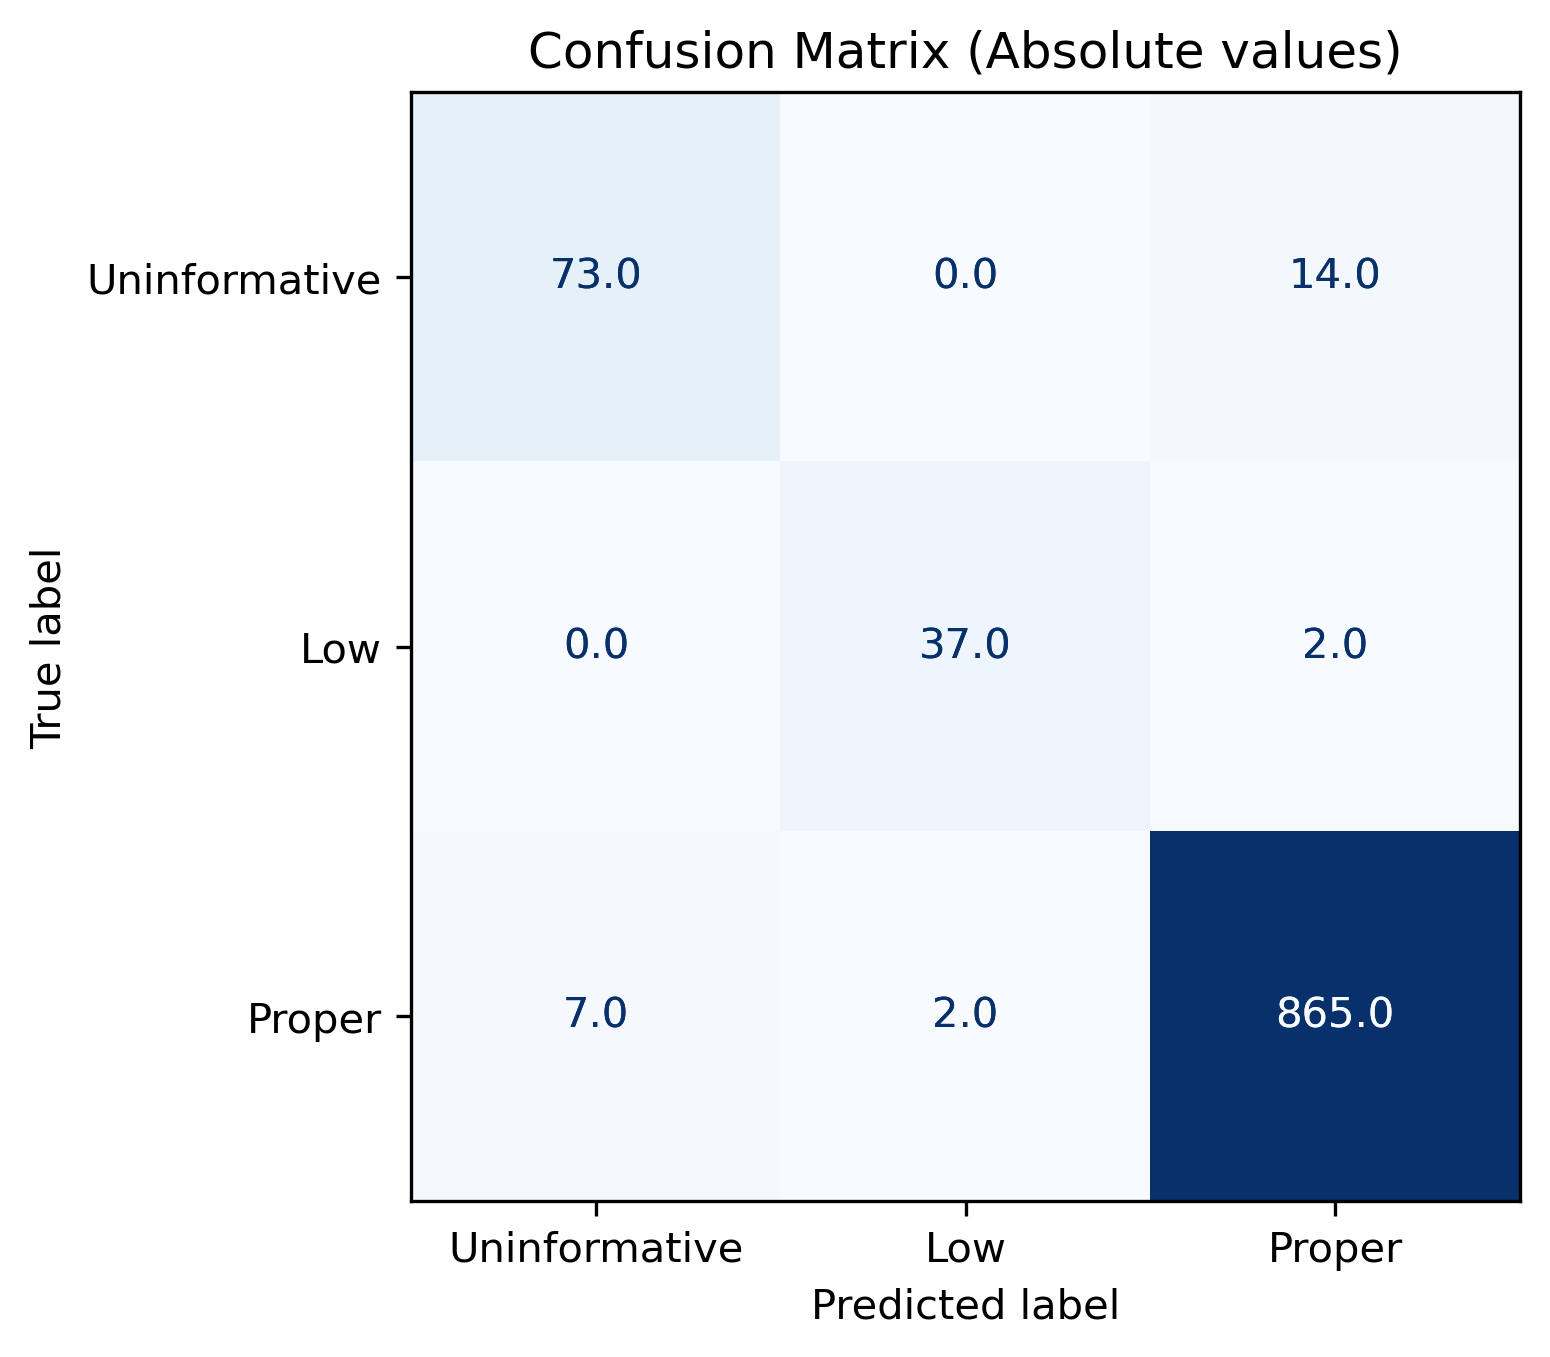
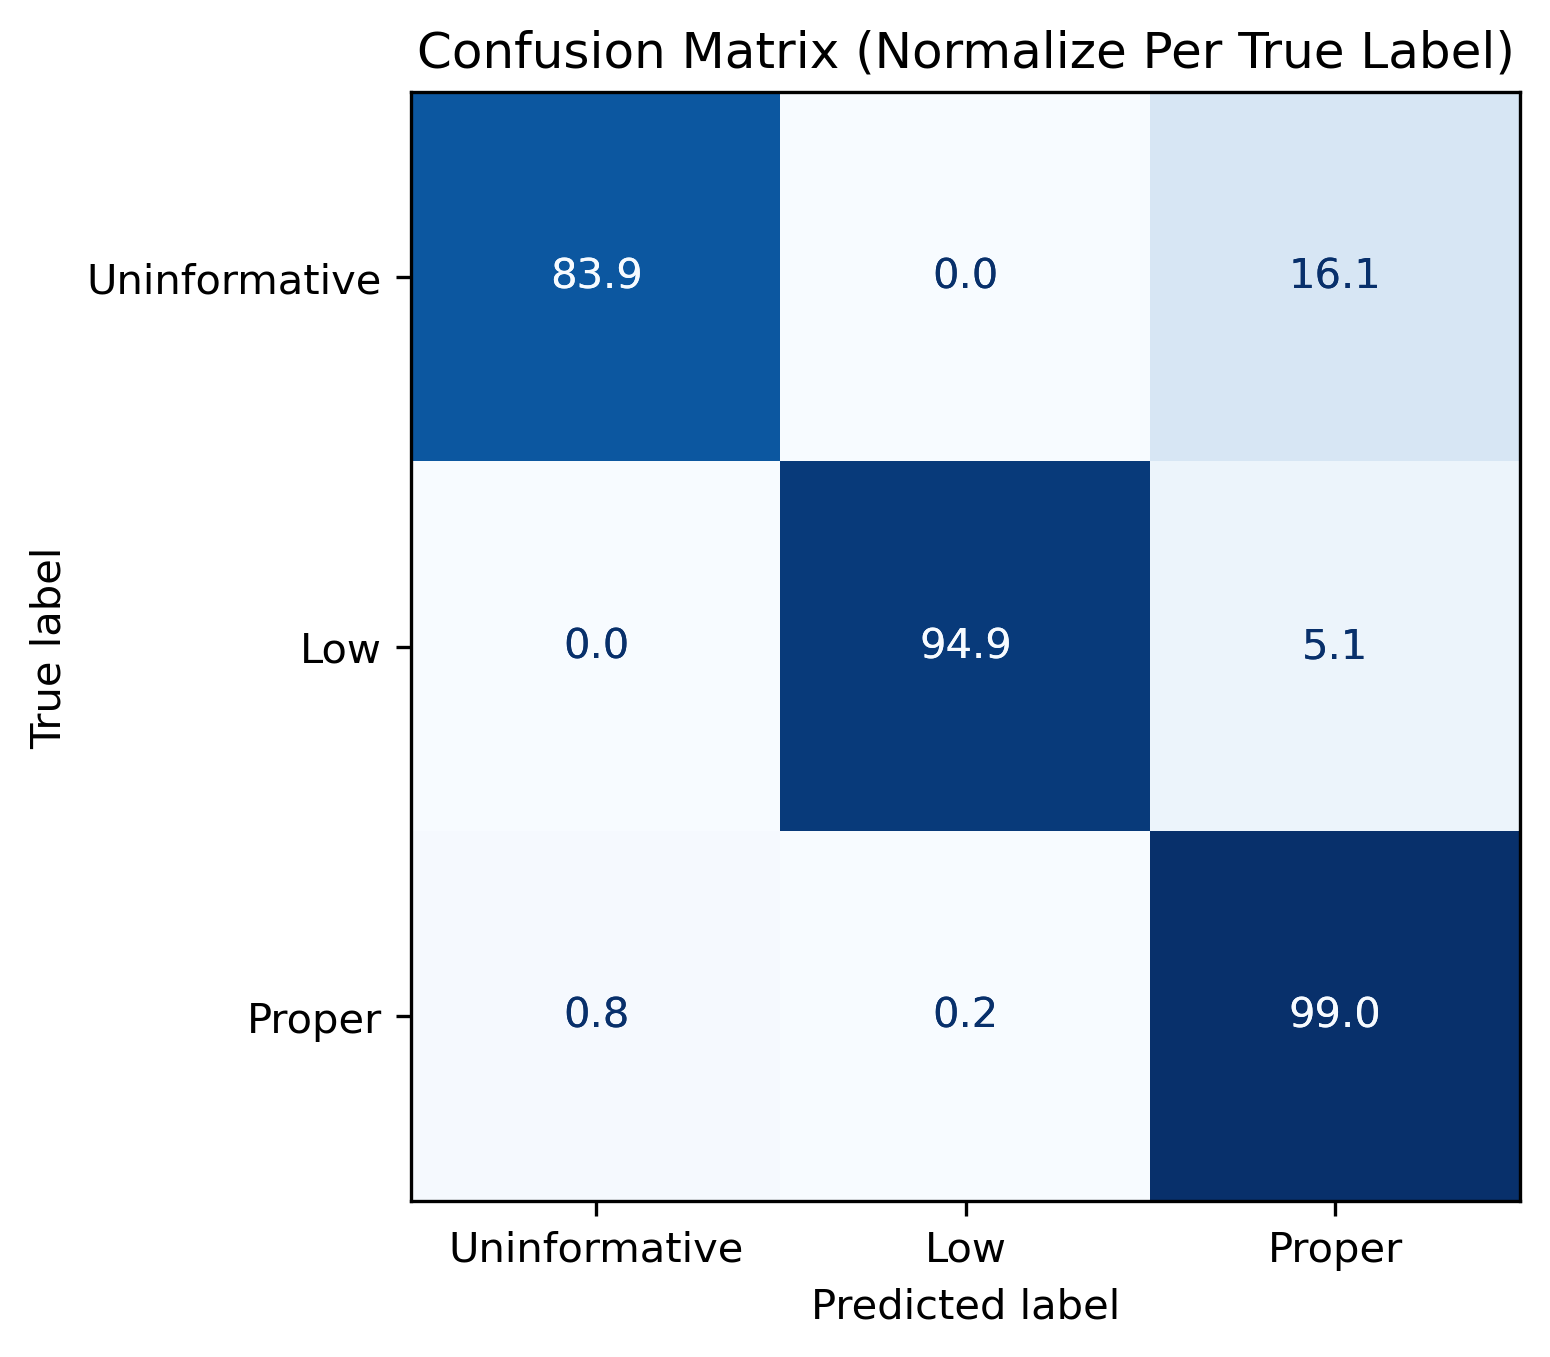

In [7]:
c_report.show_report()

In [9]:
c_report.y_preds_probs[:,2]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 3.73751500e-05, 9.88649726e-01, 9.99690533e-01,
       1.00000000e+00, 9.99737203e-01, 9.99997377e-01, 9.99993682e-01,
       1.00000000e+00, 9.99994755e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.99999523e-01, 2.34843865e-05, 1.00000000e+00,
       1.00000000e+00, 9.95648682e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.84607164e-06,
       9.70830545e-02, 9.99999881e-01, 1.00000000e+00, 3.75999987e-01,
       9.91133988e-01, 1.00000000e+00, 9.88699853e-01, 9.96087313e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99945283e-01,
       1.00000000e+00, 9.91451800e-01, 9.99999523e-01, 9.99999881e-01,
       1.00000000e+00, 1.00000000e+00, 9.99999881e-01, 1.00000000e+00,
       9.98972416e-01, 9.90266144e-01, 9.99284446e-01, 9.99958158e-01,
       9.04468596e-01, 1.00000000e+00, 9.99996781e-01, 7.76622852e-04,
      

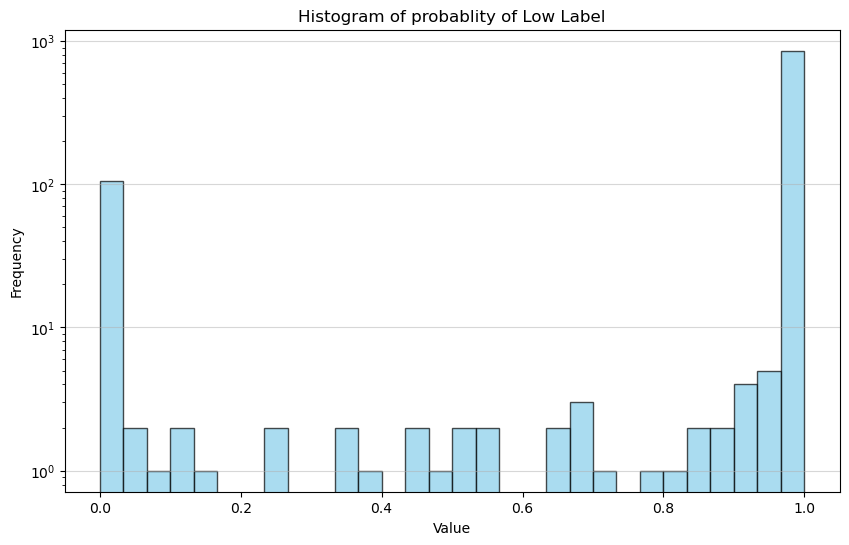

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare your data (e.g., random data for demonstration)
data = c_report.y_preds_probs[:,2]  # 1000 random values from a standard normal distribution

# 2. Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    data, 
    bins=30,  # Specify the number of bins/intervals
    color='skyblue', 
    edgecolor='black',
    alpha=0.7,  # Transparency
    log=True
)

# 3. Add labels and title for clarity
plt.title('Histogram of probablity of Low Label')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

# 4. Display the plot
plt.show()

In [32]:
import pandas as pd
self = c_report
merged_df = pd.DataFrame({
    "protein_annotation": self.eval_df["protein_annotation"],
    "true_label": self.eval_df["label"],
    "predicted_label": self.y_preds,
    "predicted_proba_0": self.y_preds_probs[:,0],
    "predicted_proba_1": self.y_preds_probs[:,1],
    "predicted_proba_2": self.y_preds_probs[:,2],
    })

miscalssified_df = merged_df[merged_df["true_label"] != merged_df["predicted_label"]]

df = miscalssified_df[miscalssified_df["predicted_label"] == 2]

df 

,protein_annotation,true_label,predicted_label,predicted_proba_0,predicted_proba_1,predicted_proba_2
35,Bordetella phage Bbp38 like protein,0,2,3.889030e-03,2.363632e-05,0.996087
52,Protein A,0,2,9.552823e-02,3.161614e-06,0.904469
56,LvrE,0,2,2.342579e-03,5.495970e-07,0.997657
91,Cell wall protein containing Ig-like domains (...,1,2,5.528462e-07,3.219551e-06,0.999996
268,Bbp50,0,2,3.193968e-01,6.272470e-05,0.680541
353,Mu-like prophage protein gp46,0,2,4.512923e-01,3.201757e-04,0.548388
386,Putative phage protein p11,0,2,4.738905e-01,1.710492e-05,0.526092
412,Phage I-like protein,0,2,3.351799e-01,4.762087e-06,0.664815
468,"Uncharacterized protein YjbI, contains pentape...",1,2,4.945783e-02,1.968551e-04,0.950345
648,Enterobacteria phage P1,0,2,1.204645e-01,1.050295e-05,0.879525


In [34]:
correctly_classified_df = merged_df[merged_df["true_label"] == merged_df["predicted_label"]]
correctly_classified_df

,protein_annotation,true_label,predicted_label,predicted_proba_0,predicted_proba_1,predicted_proba_2
0,FecR protein,2,2,4.966146e-11,2.447119e-10,1.000000
1,Phosphatidylinositol-glycan biosynthesis class...,2,2,1.408636e-09,7.843277e-10,1.000000
2,DNA ligase-associated DEXH box helicase,2,2,7.281545e-13,8.524601e-14,1.000000
3,Putative Rac prophage prophage lambda endopept...,2,2,1.397030e-08,6.059263e-11,1.000000
4,Origin recognition complex subunit 1,2,2,2.330258e-09,3.783752e-13,1.000000
...,...,...,...,...,...,...
995,Spermidine N(1)-acetyltransferase,2,2,7.902415e-09,2.568958e-08,1.000000
996,RIR2B,2,2,5.309956e-04,2.230643e-09,0.999469
997,Calcineurin-like phosphoesterase superfamily d...,2,2,1.969116e-09,8.134421e-13,1.000000
998,"Replication factor C, subunit RFC5",2,2,8.786708e-16,1.245017e-17,1.000000


In [57]:
new_preds = []
for p in self.y_preds_probs:
    if p[2] > 0.99:
        new_preds.append(2)
    elif p[1] > 0.7:
        new_preds.append(1)
    else:
        new_preds.append(0)

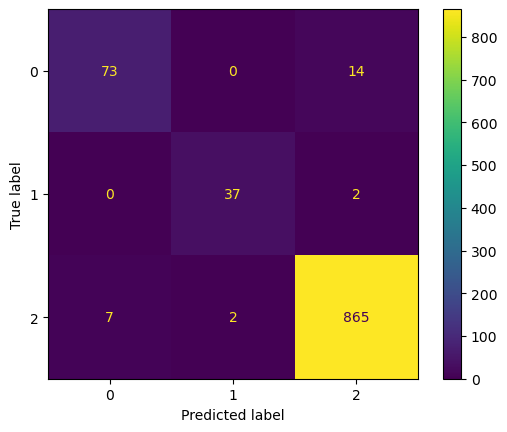

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(merged_df["true_label"], merged_df["predicted_label"])


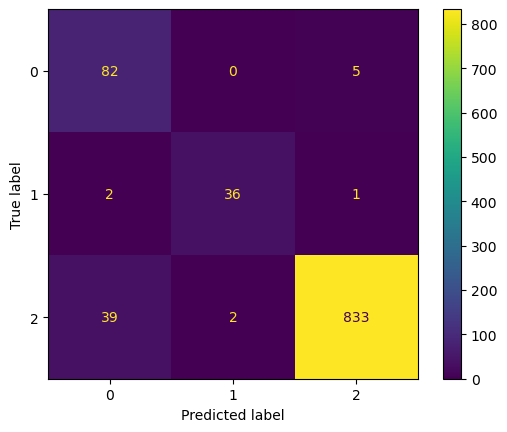

In [58]:
ConfusionMatrixDisplay.from_predictions(merged_df["true_label"], new_preds)

In [ ]:
# check if the model condifdence of Proper when it is correct and when it is incorrect
predicted_proba_of_2_when_it_is_2 = merged_df[merged_df["true_label"] == 2]["predicted_proba_2"]
predicted_proba_of_2_when_it_is_NOT_2 = merged_df[merged_df["true_label"] != 2]["predicted_proba_2"]

In [2]:
merged_df[merged_df["true_label"] != 2]

NameError: name 'merged_df' is not defined

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare your data (e.g., random data for demonstration)
data = c_report.y_preds_probs[:,2]  # 1000 random values from a standard normal distribution

# 2. Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    predicted_proba_of_2_when_it_is_NOT_2, 
    bins=30,  # Specify the number of bins/intervals
    color='skyblue', 
    edgecolor='black',
    alpha=0.7,  # Transparency
    log=True
)

# 3. Add labels and title for clarity
plt.title('Histogram of probablity of Low Label')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

# 4. Display the plot
plt.show()

NameError: name 'c_report' is not defined

In [59]:
X = dataloader.get_validation()["protein_annotation"]
y_true = dataloader.get_validation()["label"]
# proba = embedder_m.predict(list(X))
pred_prob = proba

In [57]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import RocCurveDisplay

ValueError: The target y is not binary. Got multiclass type of target.

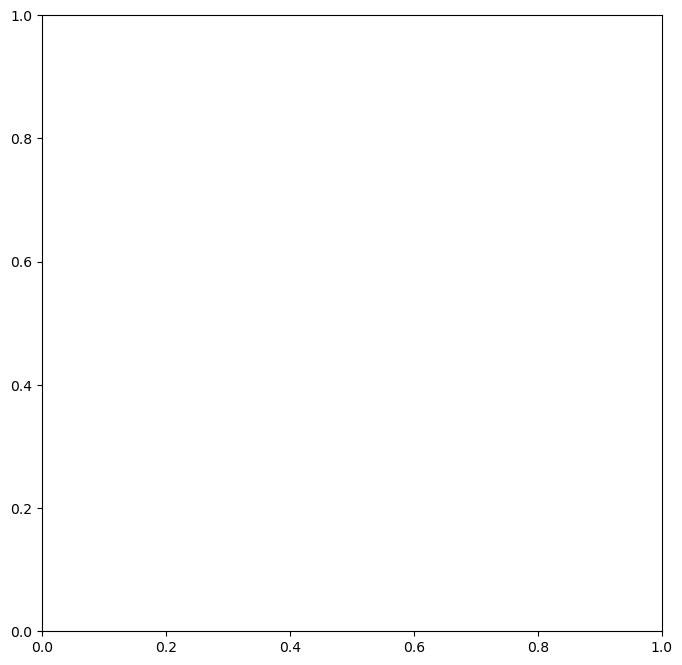

In [61]:
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.gca() # Get the current axes

roc_display = RocCurveDisplay.from_predictions(
    y_true,
    pred_prob,
    name='Custom Classifier Scores',
    ax=ax,
    color='purple' # Using a new color to signify the change
)

In [65]:
y_true_binary

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

--- Classifier Performance Metrics ---
Unweighted Average Recall (UAC) / Balanced Accuracy: 1.0000
------------------------------------------
Generating Multi-Class ROC Curve Plot (One-vs-Rest)...


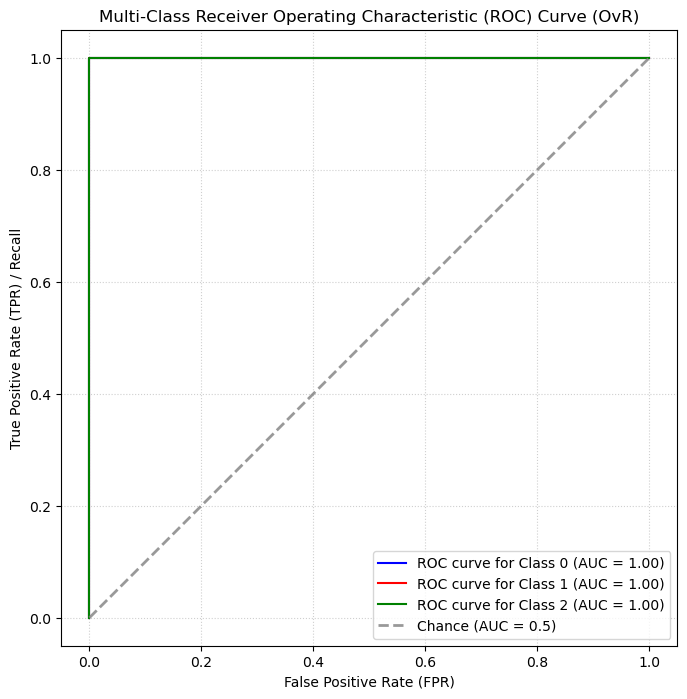

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import RocCurveDisplay
# Note: We rely only on ground truth (y_test) and probability scores (y_proba).

# 1. Configuration and Data Generation
# Set a random seed for reproducibility
np.random.seed(42)

# Create synthetic data for 3 classes
n_classes = 3
class_labels = [f'Class {i}' for i in range(n_classes)]

X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=0,
    n_classes=n_classes,
    n_clusters_per_class=1,
    weights=[0.8, 0.1, 0.1], # Imbalanced data: Class 0 is large, Classes 1 and 2 are small
    flip_y=0,
    random_state=42,
    class_sep=2.0         # Good separation in the underlying data
)

# Split data to get the final ground truth labels (y_test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Supply Predicted Probabilities (y_proba is now 2D: (n_samples, n_classes))
# --- BEGIN CUSTOM SCORE INPUT (REPLACE THIS SECTION WITH YOUR MODEL'S OUTPUTS) ---

# **Simulation Block:** Simulate a more realistic, non-perfect 3-class classifier.
y_proba = np.zeros((len(y_test), n_classes))

for i in range(len(y_test)):
    true_class = y_test[i]
    
    # ADJUSTED PERFORMANCE: Assign a realistic probability to the true class (0.55 to 0.85)
    # This range ensures AUC scores are good, but not perfect (closer to 0.8-0.9)
    y_proba[i, true_class] = 0.55 + np.random.rand() * 0.3
    
    # Distribute the remaining probability among the other two classes
    remaining_prob = 1.0 - y_proba[i, true_class]
    other_classes = [c for c in range(n_classes) if c != true_class]
    
    # Distribute remaining probability equally for simplicity
    if remaining_prob > 0:
        y_proba[i, other_classes[0]] = remaining_prob / 2
        y_proba[i, other_classes[1]] = remaining_prob / 2

# Ensure probabilities sum exactly to 1 (floating point correction)
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True)

# --- END CUSTOM SCORE INPUT ---

# 3. Calculate Unweighted Average Recall (UAC) / Balanced Accuracy
# Hard predictions are determined by the class with the highest probability
y_pred = np.argmax(y_proba, axis=1)

# balanced_accuracy_score works correctly for multi-class classification
uac_score = balanced_accuracy_score(y_test, y_pred)

print(f"--- Classifier Performance Metrics ---")
print(f"Unweighted Average Recall (UAC) / Balanced Accuracy: {uac_score:.4f}")
print("------------------------------------------")
print("Generating Multi-Class ROC Curve Plot (One-vs-Rest)...")

# 4. Generate and Plot the Multi-Class ROC Curve (One-vs-Rest)
colors = ['blue', 'red', 'green'] # Define distinct colors for each class

plt.figure(figsize=(10, 8), dpi=100)
ax = plt.gca()

# Loop through each class for the One-vs-Rest (OvR) strategy
for i in range(n_classes):
    # OvR: Convert y_test to a binary array (1 for current class, 0 for all others)
    y_true_binary = (y_test == i).astype(int)

    # The score for this OvR problem is the probability of the current class
    y_score = y_proba[:, i]

    # Use RocCurveDisplay.from_predictions
    RocCurveDisplay.from_predictions(
        y_true_binary,
        y_score,
        name=f'ROC curve for {class_labels[i]}',
        ax=ax,
        color=colors[i]
    )

# Plot the chance line (random guessing baseline)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='gray',
    label='Chance (AUC = 0.5)',
    alpha=0.8
)

# Add titles and labels
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve (OvR)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.legend(loc="lower right")
plt.grid(linestyle=':', alpha=0.6)
plt.axis('square')

plt.show()